# Importing necessary libraries and stock data

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pandas as pd
import numpy as np
from IPython.display import display
import time

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

from keras.layers import *
from keras.models import Sequential, Model

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings('ignore')

In [2]:

# Define Date Ranges
start_date = '2005-01-01'
end_date = '2020-12-31'

# Fetch the stock data
ticker_symbol = 'GOOG'
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the data
stock_data


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,4.916571,5.071989,4.868253,5.048826,5.043087,636143518
2005-01-04,5.016198,5.054305,4.818937,4.844342,4.838836,552298420
2005-01-05,4.818190,4.904118,4.787804,4.819685,4.814207,330698912
2005-01-06,4.858788,4.879212,4.675475,4.696148,4.690810,417041336
2005-01-07,4.748203,4.838116,4.701876,4.828153,4.822665,387964757
...,...,...,...,...,...,...
2020-12-23,86.405502,87.399498,86.251999,86.619003,86.520546,20676000
2020-12-24,86.750000,87.300003,86.455498,86.942497,86.843674,6936000
2020-12-28,87.581749,89.536400,87.316750,88.804497,88.703560,27860000


# Plotting basic regression

In [3]:
data=stock_data.copy()
data = data.reset_index()

In [4]:
# Split data into train and test set: 80% / 20%
train, test = train_test_split(data, test_size=0.20)
# Reshape index column to 2D array for .fit() method
X_train = np.array(train.index).reshape(-1, 1)
y_train = train['Adj Close']
# Create LinearRegression Object
model = LinearRegression()
# Fit linear model using the train data set
model.fit(X_train, y_train)

LinearRegression()

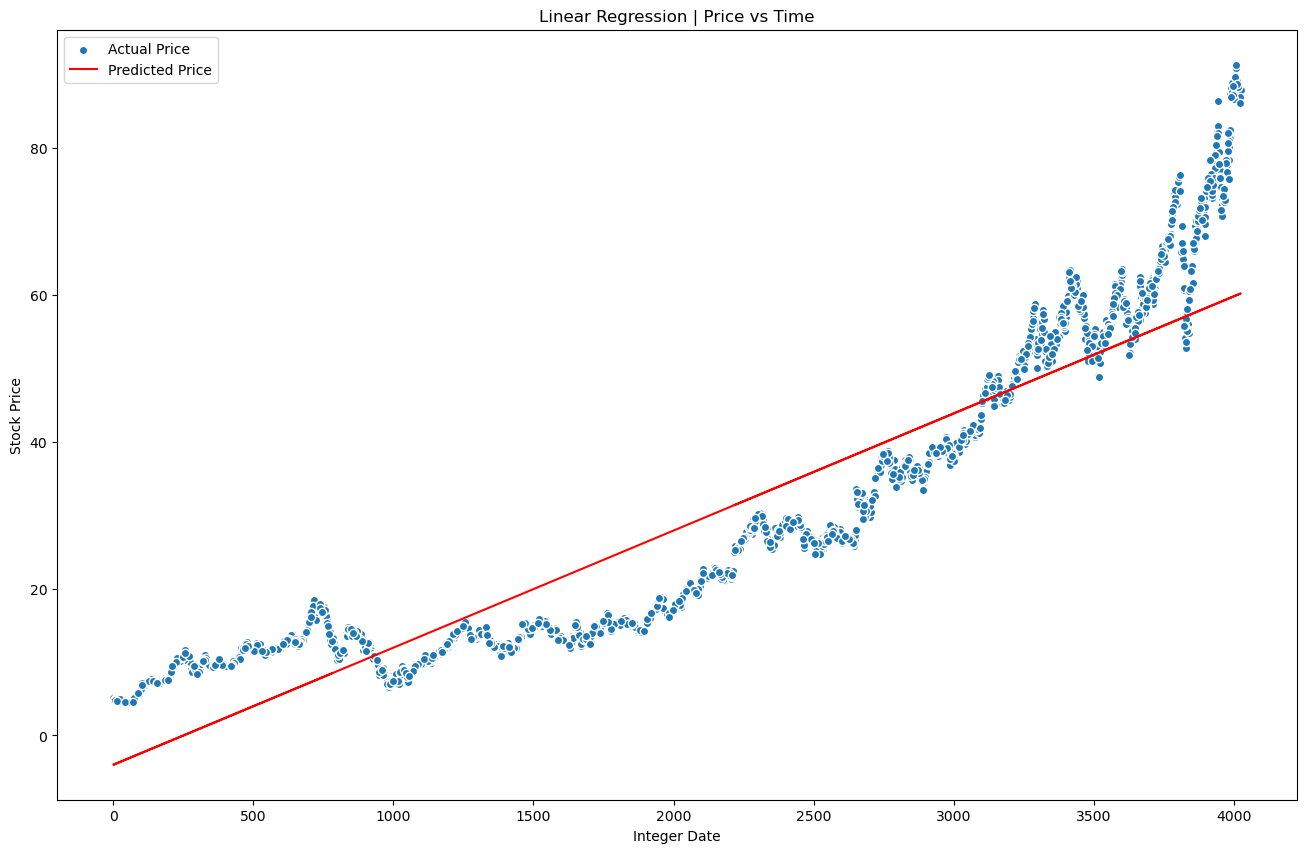

In [5]:
# Train set graph
plt.figure(1, figsize=(16,10))
plt.title('Linear Regression | Price vs Time')
plt.scatter(X_train, y_train, edgecolor='w', label='Actual Price')
plt.plot(X_train, model.predict(X_train), color='r', label='Predicted Price')
plt.xlabel('Integer Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [6]:
# Create test arrays
X_test = np.array(test.index).reshape(-1, 1)
y_test = test['Close']
# Generate array with predicted values
y_pred = model.predict(X_test)

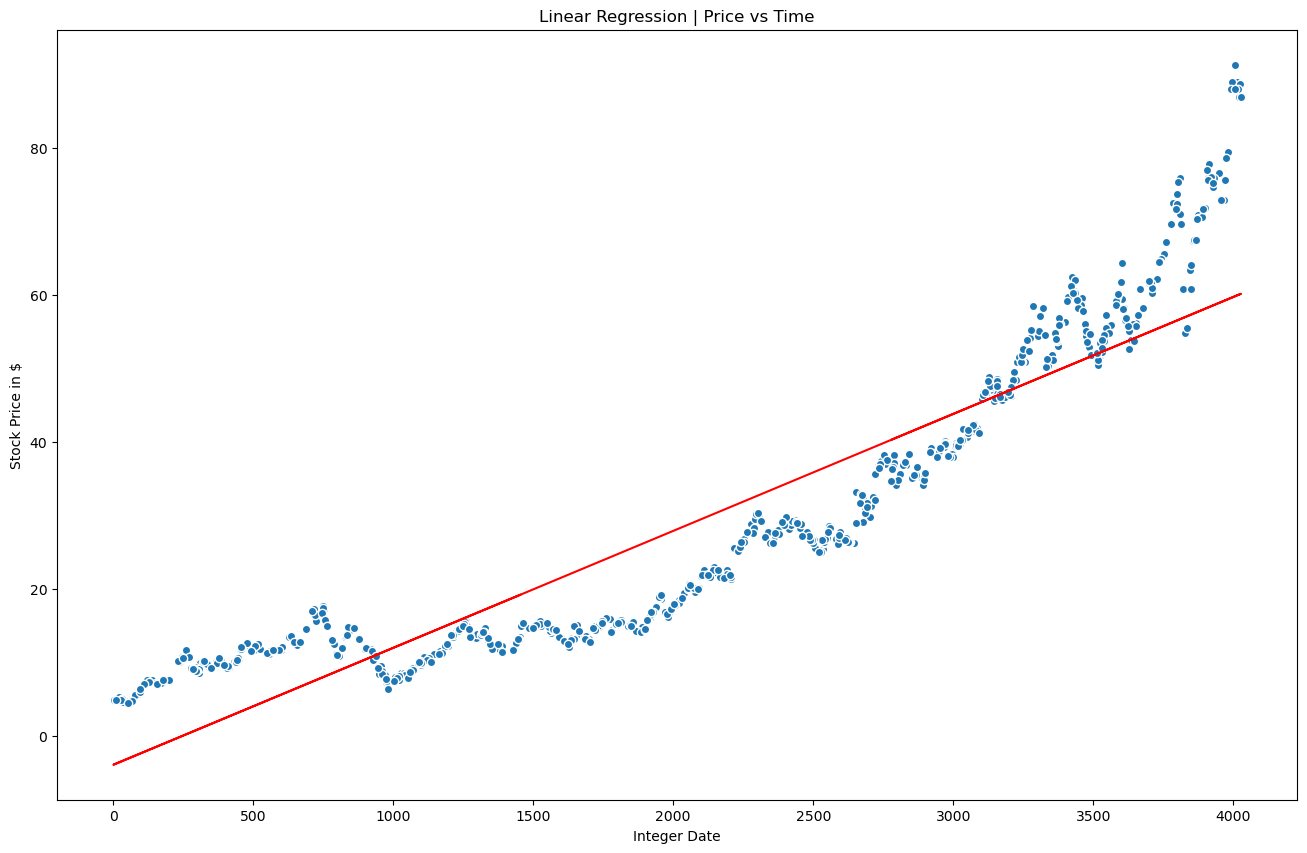

In [7]:
# Plot fitted line, y test
plt.figure(1, figsize=(16,10))
plt.title('Linear Regression | Price vs Time')
plt.plot(X_test, model.predict(X_test), color='r', label='Predicted Price')
plt.scatter(X_test, y_test, edgecolor='w', label='Actual Price')

plt.xlabel('Integer Date')
plt.ylabel('Stock Price in $')

plt.show()

# Training LSTM network with previous close and volume data using log normalisation

In [8]:
seq_length = 60
step_predict = 5

In [13]:
df=stock_data.copy()
df['close_log'] = np.log(df['Close'] / df['Close'].shift(1))
df['vol_log'] = np.log(df['Volume'] / df['Volume'].shift(1))
df['target_log'] = np.log(df['Close'].shift(-step_predict) / df['Close'])
df = df.reset_index(drop=True)
df.dropna(inplace=True)
length=df.shape[0]
df

,Open,High,Low,Close,Adj Close,Volume,close_log,vol_log,target_log
1,5.016198,5.054305,4.818937,4.844342,4.838836,552298420,-0.041344,-0.141336,-0.004948
2,4.818190,4.904118,4.787804,4.819685,4.814207,330698912,-0.005103,-0.512880,0.009617
3,4.858788,4.879212,4.675475,4.696148,4.690810,417041336,-0.025966,0.231977,0.035327
4,4.748203,4.838116,4.701876,4.828153,4.822665,387964757,0.027721,-0.072271,0.031083
5,4.844342,4.934006,4.777841,4.858290,4.852768,302714411,0.006223,-0.248125,0.044322
...,...,...,...,...,...,...,...,...,...
4017,88.643997,88.650002,87.804001,88.150002,88.049805,30270000,-0.002702,0.020830,-0.017521
4018,88.425499,88.589203,86.932999,87.394997,87.295662,32494000,-0.008602,0.070898,-0.005191
4019,87.709000,87.755501,86.011002,86.550499,86.452118,80328000,-0.009710,0.905063,0.025709
4020,85.675499,87.042503,84.949997,86.968498,86.869644,36568000,0.004818,-0.786945,0.011063


In [14]:
train_df = df[:int(length*0.75)].copy()
train_df.reset_index(inplace=True)
val_df = df[int(length*0.75):int(length*0.8)].copy()
val_df.reset_index(inplace=True)
test_df = df.loc[int(length*0.8):].copy()
test_df.reset_index(inplace=True)
train_df.shape, val_df.shape, test_df.shape

((3015, 10), (201, 10), (806, 10))

In [15]:
X_train = []
y_train = []
for i in range(seq_length, train_df.shape[0]-step_predict):
    X_train.append(train_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_train.append(train_df.loc[i-1, 'target_log'])
X_train, y_train= np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
X_train.shape, y_train.shape

((2950, 59, 2), (2950,))

In [16]:
X_val = []
y_val = []
for i in range(seq_length, val_df.shape[0]-step_predict):
    X_val.append(val_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_val.append(val_df.loc[i-1, 'target_log'])
X_val, y_val= np.array(X_val), np.array(y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 2))
X_val.shape, y_val.shape

((136, 59, 2), (136,))

In [17]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [19]:
inputs = Input(shape=(X_train.shape[1], 2))
lstm1 = LSTM(units=50, return_sequences=True)(inputs)
dropout1 = Dropout(rate=0.5)(lstm1)
lstm2 = LSTM(units=50, return_sequences=True)(dropout1)
dropout2 = Dropout(rate=0.5)(lstm2)
lstm3 = LSTM(units=50)(dropout2)
dropout3 = Dropout(rate=0.5)(lstm3)
fc1 = Dense(units=100)(dropout3)
fc2 = Dense(units=50)(fc1)
fc3 = Dense(units=25)(fc2)
output = Dense(units=1)(fc3)

lstm_model = Model(inputs=inputs, outputs=output)
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_model.fit(X_train, y_train, epochs = 20, batch_size = 32, validation_data=(X_val, y_val))

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - loss: 0.0021 - val_loss: 5.8514e-04
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0019 - val_loss: 5.8275e-04
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.0018 - val_loss: 6.4405e-04
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.0019 - val_loss: 6.0545e-04
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0019 - val_loss: 6.1573e-04
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0017 - val_loss: 5.7373e-04
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0018 - val_loss: 6.0387e-04
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0018 - val_loss: 5.9260e-04
Epoch 9/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.0019 - val_loss: 5.9034e-04
Epoch 10/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.0018 - val_loss: 5.9575e-04
Epoch 11/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0017 - val_loss: 5.7478e-04
Epoch 12/

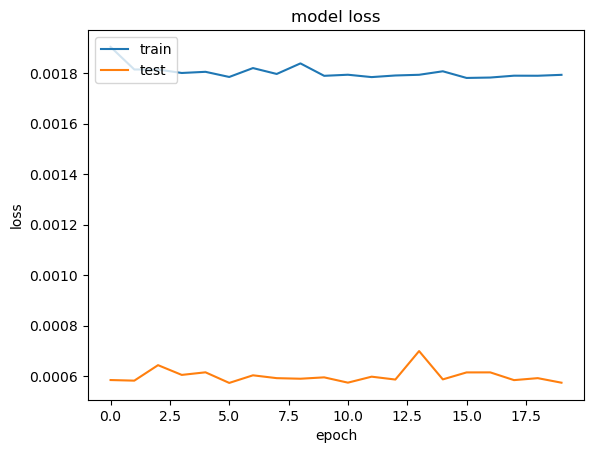

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
train_price = train_df[seq_length+step_predict:train_df.shape[0]].Close
train_predicted = lstm_model.predict(X_train)
# train_predicted = sc.inverse_transform(train_predicted)
inv = train_df[seq_length:train_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
train_predicted = inv * np.exp(1)**train_predicted
len(train_price), len(train_predicted)

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


(2950, 2950)

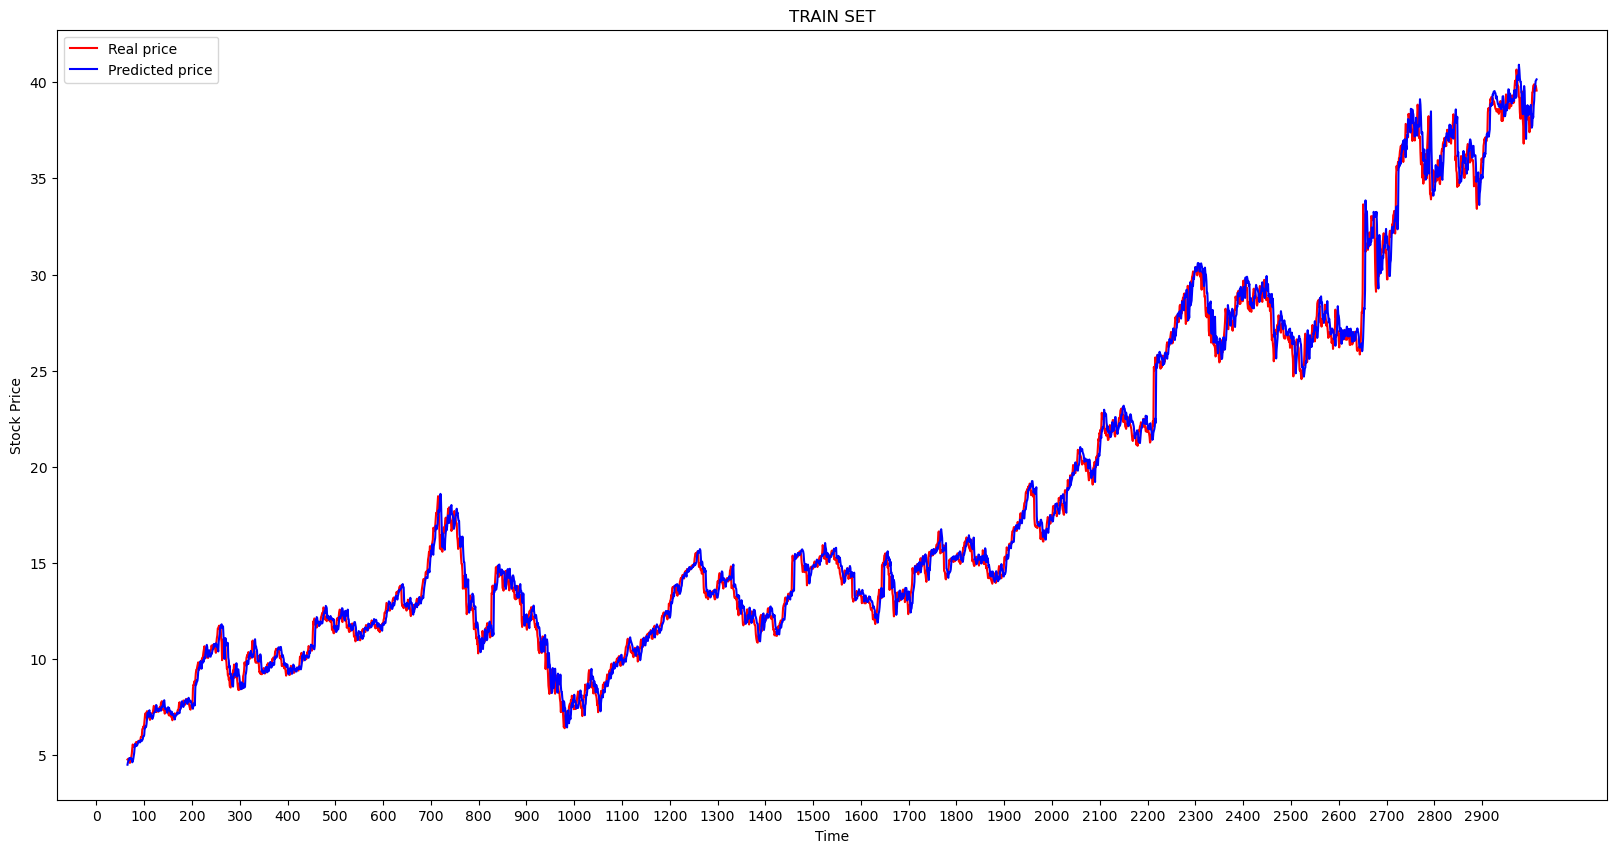

RMSE: 0.7181521893783953


In [23]:
# Visualising the results
date = train_df[seq_length+step_predict:train_df.shape[0]].index.values
plt.figure(figsize=(20,10))
plt.plot(date, train_price, color = 'red', label = 'Real price')
plt.plot(date, train_predicted, color = 'blue', label = 'Predicted price')
plt.xticks(np.arange(0,len(train_predicted),100))
plt.title('TRAIN SET')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(train_price, train_predicted, squared=False)}')

In [24]:
val_price = val_df[seq_length+step_predict:val_df.shape[0]].Close
val_predicted = lstm_model.predict(X_val)
# val_predicted = sc.inverse_transform(val_predicted)
inv = val_df[seq_length:val_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
val_predicted = inv * np.exp(1)**val_predicted
len(val_price), len(val_predicted)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


(136, 136)

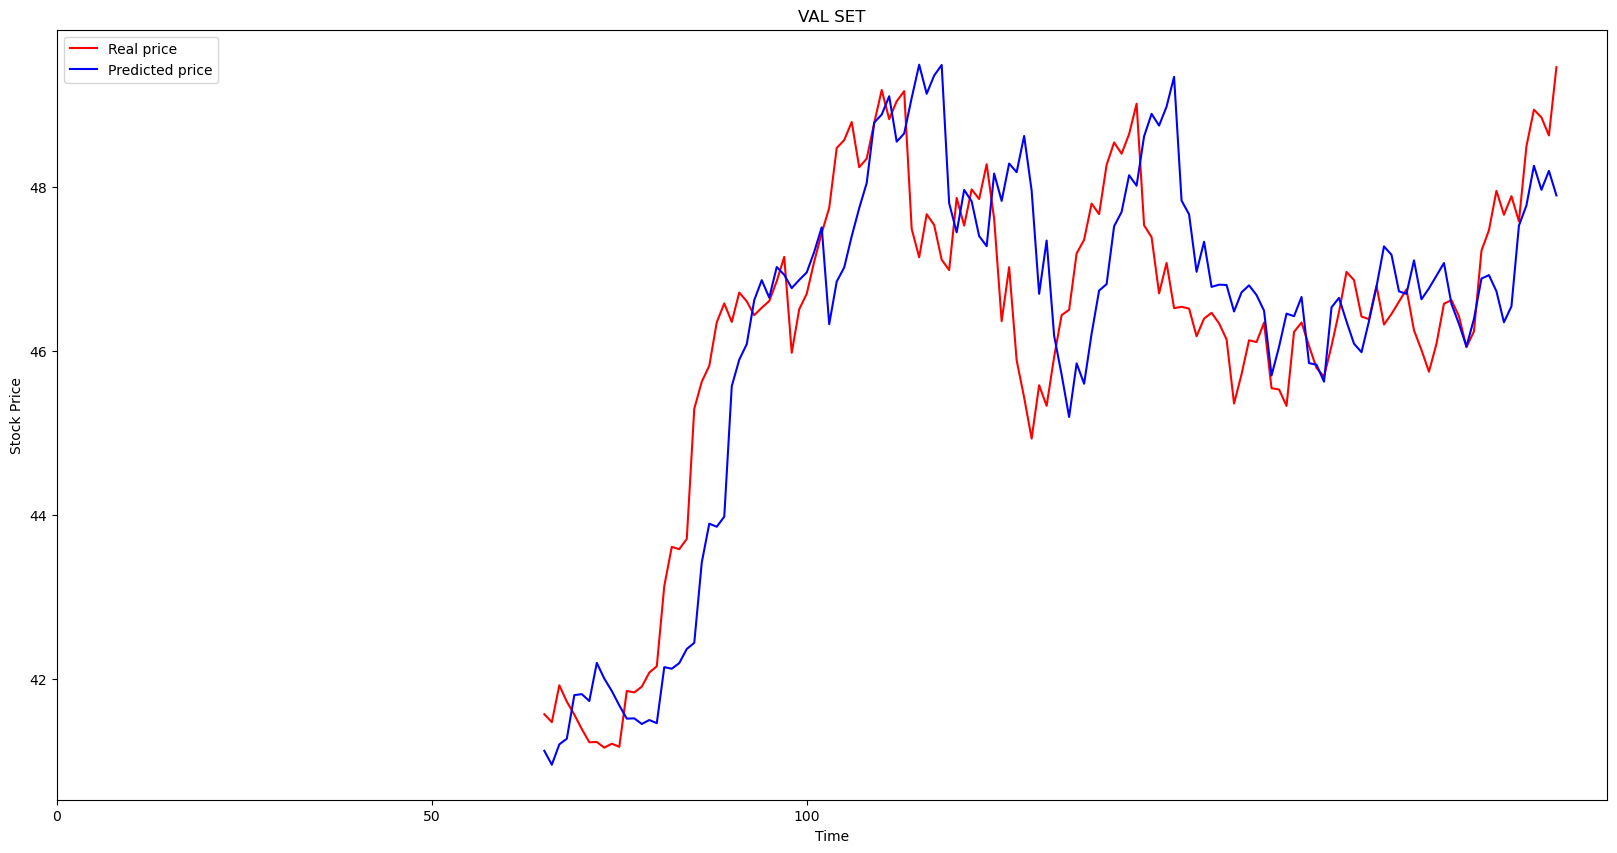

RMSE: 1.1189458976360773


In [25]:
# Visualising the results
date = val_df[seq_length+step_predict:val_df.shape[0]].index.values
plt.figure(figsize=(20,10))
plt.plot(date, val_price, color = 'red', label = 'Real price')
plt.plot(date, val_predicted, color = 'blue', label = 'Predicted price')
plt.xticks(np.arange(0,len(val_predicted),50))
plt.title('VAL SET')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(val_price, val_predicted, squared=False)}')

In [26]:
X_test = []
y_test = []
for i in range(seq_length, test_df.shape[0]-step_predict):
    X_test.append(test_df[i-seq_length+1: i][['close_log', 'vol_log']].values)
    y_test.append(test_df.loc[i-1, 'target_log'])
X_test, y_test= np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
X_test.shape, y_test.shape

((741, 59, 2), (741,))

In [27]:
test_price = test_df[seq_length+step_predict:test_df.shape[0]].Close
test_predicted = lstm_model.predict(X_test)
# test_predicted = sc.inverse_transform(test_predicted)
inv = test_df[seq_length:test_df.shape[0]-step_predict].Close.values.reshape(-1, 1)
test_predicted = inv * np.exp(1)**test_predicted
len(test_price), len(test_predicted)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


(741, 741)

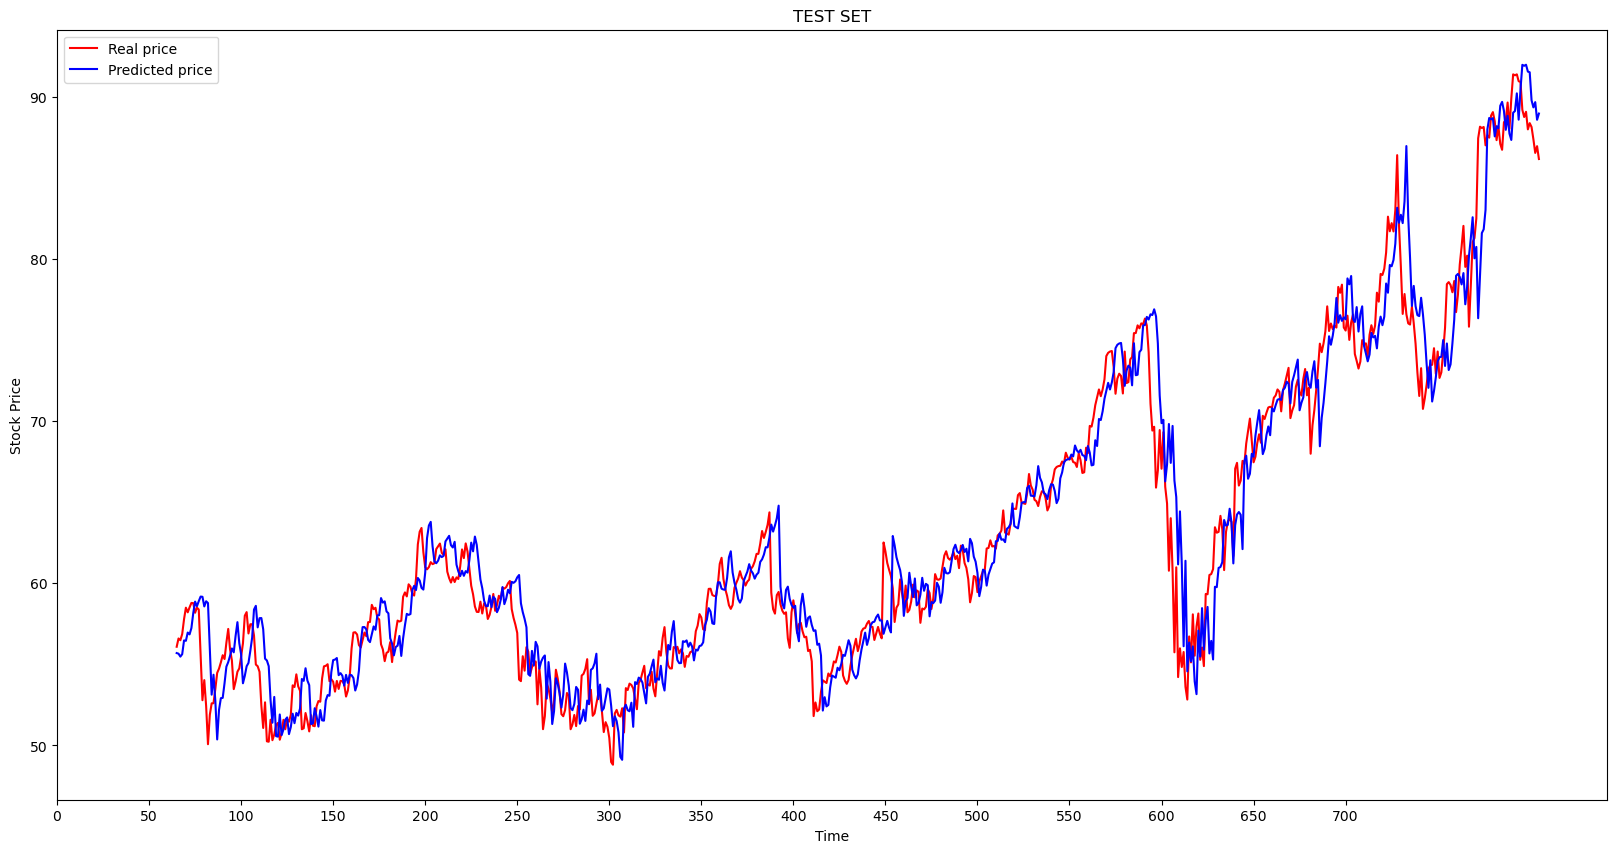

RMSE: 2.4419516290860876


In [29]:
# Visualising the results
date = test_df[seq_length+step_predict:test_df.shape[0]].index.values
plt.figure(figsize=(20,10))
plt.plot(date, test_price, color = 'red', label = 'Real price')
plt.plot(date, test_predicted, color = 'blue', label = 'Predicted price')
plt.xticks(np.arange(0,len(test_predicted),50))
plt.title('TEST SET')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
print(f'RMSE: {mean_squared_error(test_price, test_predicted, squared=False)}')

# Exploratory Data Analysis and Feature Selection

In [45]:
#Created a new dataframe and added a variety of relevant technical indicators so as to make accurate predictions 

df = stock_data.copy()

# Add Year, Month, and Day columns
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

# Calculate 14-day Simple Moving Average (SMA) using 'Adj Close'
df['SMA_14'] = df['Adj Close'].rolling(window=14).mean()

# Calculate 14-day Exponential Moving Average (EMA) using 'Adj Close'
df['EMA_14'] = df['Adj Close'].ewm(span=14, adjust=False).mean()

# Calculate Cumulative Moving Average (CMA) using 'Adj Close'
df['CMA'] = df['Adj Close'].expanding().mean()

# Calculate Daily Return
df['Daily Return'] = df['Adj Close'].pct_change()

# Calculate MACD
df['EMA_12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD Histogram'] = df['MACD'] - df['Signal Line']




In [46]:
# Calculate Stochastic Oscillator
n = 14  # Period for Stochastic Oscillator

# Calculate the highest high and lowest low over the last n days
df['14 High'] = df['High'].rolling(window=n).max()
df['14 Low'] = df['Low'].rolling(window=n).min()

# Calculate %K and %D
df['%K'] = (df['Adj Close'] - df['14 Low']) / (df['14 High'] - df['14 Low']) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

#High-Low (volatility indicator)
high_low=df['High']-df['Low']
df['high_low']=high_low

# RSI (14-day)
change = df["Adj Close"].diff()
change.dropna(inplace=True)
change_up = change.copy()
change_down = change.copy()
change_up[change_up<0] = 0
change_down[change_down>0] = 0
change.equals(change_up+change_down)
avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()
rsi = 100 * avg_up / (avg_up + avg_down)
df['RSI'] = rsi
df.RSI=df.RSI.fillna(df.RSI.median())

#VWAP
df['VWAP'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()

In [47]:
df.dropna(inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,SMA_14,...,MACD,Signal Line,MACD Histogram,14 High,14 Low,%K,%D,high_low,RSI,VWAP
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-25,4.531515,4.538987,4.390792,4.411465,4.406451,427966132,2005,1,25,4.791621,...,-0.102453,-0.058298,-0.044154,5.113334,4.390792,2.167189,1.638118,0.148195,33.033969,4.830799
2005-01-26,4.465014,4.717567,4.462025,4.713333,4.707976,494161321,2005,1,26,4.784033,...,-0.098400,-0.066319,-0.032081,5.113334,4.390792,43.898326,15.614832,0.255542,46.575771,4.816883
2005-01-27,4.701378,4.703869,4.612710,4.684442,4.679117,266089645,2005,1,27,4.783197,...,-0.096406,-0.072336,-0.024070,5.113334,4.390792,39.904282,28.656599,0.091159,49.598627,4.811466
2005-01-28,4.732760,4.849324,4.641104,4.740731,4.735342,490158373,2005,1,28,4.776960,...,-0.089260,-0.075721,-0.013539,5.113334,4.390792,47.685809,43.829472,0.208220,46.838395,4.807237
2005-01-31,4.824168,4.890669,4.775102,4.872238,4.866700,385306832,2005,1,31,4.777955,...,-0.072165,-0.075010,0.002845,5.113334,4.390792,65.865803,51.151965,0.115567,50.469969,4.809050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,86.405502,87.399498,86.251999,86.619003,86.520546,20676000,2020,12,23,88.371722,...,0.111698,0.763471,-0.651774,91.713501,84.949997,23.220937,21.445657,1.147499,20.430999,15.523420
2020-12-24,86.750000,87.300003,86.455498,86.942497,86.843674,6936000,2020,12,24,88.053726,...,0.044395,0.619656,-0.575261,91.713501,84.949997,27.998457,22.143090,0.844505,22.964874,15.524365
2020-12-28,87.581749,89.536400,87.316750,88.804497,88.703560,27860000,2020,12,28,87.898938,...,0.139526,0.523630,-0.384104,91.713501,84.949997,55.497312,35.572235,2.219650,38.793325,15.528249


In [48]:

def backwardElimination(x, Y, sl, columns):
    # Add a column of ones to the independent variables
    x = sm.add_constant(x)
    const_col_added = True
    
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if regressor_OLS.pvalues[j].astype(float) == maxVar:
                    if j == 0 and const_col_added:
                        # If the constant column is the one with the highest p-value, skip deletion
                        const_col_added = False
                        x = x[:, 1:]  # Remove the constant column
                        print(f"Removing constant column with p-value {maxVar}")
                        continue
                    else:
                        print(f"Deleting column {columns[j-1]} with p-value {maxVar}")
                        x = np.delete(x, j, 1)
                        columns = np.delete(columns, j-1)  # Adjust index for the columns
                        break  # Exit the inner loop after deletion

    # Print the summary of the final regressor
    print(regressor_OLS.summary())

    # Remove the constant column if it's still present
    if const_col_added:
        x = x[:, 1:]

    return x, columns


In [49]:
# Lagged Adj Close (5 days later)
df['Adj Close Future'] = df['Adj Close'].shift(-5)

# Define features (X) and target variable (Y)
X = df[df.columns]  # Example features
Y = df['Adj Close Future'].dropna()

# Remove the last 5 rows and last column from X
X = X.iloc[:-5, :-1]

In [50]:
X

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day,SMA_14,...,MACD,Signal Line,MACD Histogram,14 High,14 Low,%K,%D,high_low,RSI,VWAP
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-25,4.531515,4.538987,4.390792,4.411465,4.406451,427966132,2005,1,25,4.791621,...,-0.102453,-0.058298,-0.044154,5.113334,4.390792,2.167189,1.638118,0.148195,33.033969,4.830799
2005-01-26,4.465014,4.717567,4.462025,4.713333,4.707976,494161321,2005,1,26,4.784033,...,-0.098400,-0.066319,-0.032081,5.113334,4.390792,43.898326,15.614832,0.255542,46.575771,4.816883
2005-01-27,4.701378,4.703869,4.612710,4.684442,4.679117,266089645,2005,1,27,4.783197,...,-0.096406,-0.072336,-0.024070,5.113334,4.390792,39.904282,28.656599,0.091159,49.598627,4.811466
2005-01-28,4.732760,4.849324,4.641104,4.740731,4.735342,490158373,2005,1,28,4.776960,...,-0.089260,-0.075721,-0.013539,5.113334,4.390792,47.685809,43.829472,0.208220,46.838395,4.807237
2005-01-31,4.824168,4.890669,4.775102,4.872238,4.866700,385306832,2005,1,31,4.777955,...,-0.072165,-0.075010,0.002845,5.113334,4.390792,65.865803,51.151965,0.115567,50.469969,4.809050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-16,88.643997,88.650002,87.804001,88.150002,88.049805,30270000,2020,12,16,89.558193,...,1.015188,1.602083,-0.586895,92.360001,87.015999,19.345163,22.853213,0.846001,48.058583,15.497727
2020-12-17,88.425499,88.589203,86.932999,87.394997,87.295662,32494000,2020,12,17,89.396627,...,0.812831,1.444232,-0.631401,92.360001,86.932999,6.682571,16.610203,1.656204,39.239696,15.502204
2020-12-18,87.709000,87.755501,86.011002,86.550499,86.452118,80328000,2020,12,18,89.290569,...,0.577735,1.270933,-0.693198,92.360001,86.011002,6.947809,10.991848,1.744499,42.372564,15.513135


In [51]:
Y

Date
2005-01-25     4.774152
2005-01-26     5.123941
2005-01-27     5.245845
2005-01-28     5.084136
2005-01-31     4.876899
                ...    
2020-12-16    86.520546
2020-12-17    86.843674
2020-12-18    88.703560
2020-12-21    87.836044
2020-12-22    86.877136
Name: Adj Close Future, Length: 4007, dtype: float64

In [52]:
#Choosing standard value of 0.05 as cutoff
SL = 0.05 
data_modeled, selected_columns = backwardElimination(X.values, Y.values, SL, X.columns.values)

Deleting column RSI with p-value 0.8660989799706466
Deleting column EMA_26 with p-value 0.8248461654915509
Deleting column MACD with p-value 0.8428698163035319
Deleting column Volume with p-value 0.8085037536939029
Deleting column EMA_12 with p-value 0.7650635926951591
Deleting column Signal Line with p-value 0.8604719687445181
Deleting column high_low with p-value 0.5816580099255884
Deleting column Day with p-value 0.4805096894697607
Deleting column Daily Return with p-value 0.4625535835174607
Deleting column 14 High with p-value 0.07037282269099861
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 7.544e+04
Date:                Wed, 10 Jul 2024   Prob (F-statistic):               0.00
Time:                        23:07:29   Log-Like

In [53]:
print(len(selected_columns))
print(selected_columns)

15
['Open' 'High' 'Low' 'Close' 'Adj Close' 'Year' 'Month' 'SMA_14' 'EMA_14'
 'CMA' 'MACD Histogram' '14 Low' '%K' '%D' 'VWAP']


In [54]:
print(data_modeled.shape)

(4007, 15)


In [55]:
df = pd.DataFrame(data = data_modeled, columns = selected_columns)
df

,Open,High,Low,Close,Adj Close,Year,Month,SMA_14,EMA_14,CMA,MACD Histogram,14 Low,%K,%D,VWAP
0,4.531515,4.538987,4.390792,4.411465,4.406451,2005.0,1.0,4.791621,4.773874,4.810288,-0.044154,4.390792,2.167189,1.638118,4.830799
1,4.465014,4.717567,4.462025,4.713333,4.707976,2005.0,1.0,4.784033,4.765087,4.804270,-0.032081,4.390792,43.898326,15.614832,4.816883
2,4.701378,4.703869,4.612710,4.684442,4.679117,2005.0,1.0,4.783197,4.753625,4.797317,-0.024070,4.390792,39.904282,28.656599,4.811466
3,4.732760,4.849324,4.641104,4.740731,4.735342,2005.0,1.0,4.776960,4.751187,4.794055,-0.013539,4.390792,47.685809,43.829472,4.807237
4,4.824168,4.890669,4.775102,4.872238,4.866700,2005.0,1.0,4.777955,4.766589,4.797687,0.002845,4.390792,65.865803,51.151965,4.809050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002,88.643997,88.650002,87.804001,88.150002,88.049805,2020.0,12.0,89.558193,88.845905,27.903524,-0.586895,87.015999,19.345163,22.853213,15.497727
4003,88.425499,88.589203,86.932999,87.394997,87.295662,2020.0,12.0,89.396627,88.639206,27.918301,-0.631401,86.932999,6.682571,16.610203,15.502204
4004,87.709000,87.755501,86.011002,86.550499,86.452118,2020.0,12.0,89.290569,88.347594,27.932862,-0.693198,86.011002,6.947809,10.991848,15.513135
4005,85.675499,87.042503,84.949997,86.968498,86.869644,2020.0,12.0,89.081057,88.150534,27.947519,-0.680534,84.949997,25.906157,13.178846,15.518079


# Building improved LSTM model using selected features 

In [81]:
train_data=df.copy()
train_data

,Open,High,Low,Close,Adj Close,Year,Month,SMA_14,EMA_14,CMA,MACD Histogram,14 Low,%K,%D,VWAP
0,4.531515,4.538987,4.390792,4.411465,4.406451,2005.0,1.0,4.791621,4.773874,4.810288,-0.044154,4.390792,2.167189,1.638118,4.830799
1,4.465014,4.717567,4.462025,4.713333,4.707976,2005.0,1.0,4.784033,4.765087,4.804270,-0.032081,4.390792,43.898326,15.614832,4.816883
2,4.701378,4.703869,4.612710,4.684442,4.679117,2005.0,1.0,4.783197,4.753625,4.797317,-0.024070,4.390792,39.904282,28.656599,4.811466
3,4.732760,4.849324,4.641104,4.740731,4.735342,2005.0,1.0,4.776960,4.751187,4.794055,-0.013539,4.390792,47.685809,43.829472,4.807237
4,4.824168,4.890669,4.775102,4.872238,4.866700,2005.0,1.0,4.777955,4.766589,4.797687,0.002845,4.390792,65.865803,51.151965,4.809050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4002,88.643997,88.650002,87.804001,88.150002,88.049805,2020.0,12.0,89.558193,88.845905,27.903524,-0.586895,87.015999,19.345163,22.853213,15.497727
4003,88.425499,88.589203,86.932999,87.394997,87.295662,2020.0,12.0,89.396627,88.639206,27.918301,-0.631401,86.932999,6.682571,16.610203,15.502204
4004,87.709000,87.755501,86.011002,86.550499,86.452118,2020.0,12.0,89.290569,88.347594,27.932862,-0.693198,86.011002,6.947809,10.991848,15.513135
4005,85.675499,87.042503,84.949997,86.968498,86.869644,2020.0,12.0,89.081057,88.150534,27.947519,-0.680534,84.949997,25.906157,13.178846,15.518079


In [82]:
prediction_time=5
test_data_size=int(0.2*train_data.shape[0])
unroll_length=60

test_data_cut = test_data_size + unroll_length + 1

x_train = train_data[0:-prediction_time - test_data_cut].values
y_train = train_data[prediction_time:-test_data_cut]['Close'].values

# test data
x_test = train_data[0 - test_data_cut:-prediction_time].values
y_test = train_data[prediction_time - test_data_cut:]['Close'].values

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((3140, 15), (857, 15), (3140,), (857,))

In [83]:

# Create separate scalers for each dataset
scaler_x_train = MinMaxScaler()
scaler_x_test = MinMaxScaler()
scaler_y_train = MinMaxScaler()
scaler_y_test = MinMaxScaler()

# Apply the scalers to the datasets
x_train = scaler_x_train.fit_transform(x_train)
x_test = scaler_x_test.fit_transform(x_test)
y_train = scaler_y_train.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y_test.fit_transform(y_test.reshape(-1, 1))

# If you need to inverse transform later, you can use the same scalers
# y_train_original = scaler_y_train.inverse_transform(y_train_scaled)
# y_test_original = scaler_y_test.inverse_transform(y_test_scaled)


In [84]:
def unroll(data, sequence_length=24):
    """
    use different windows for testing and training to stop from leak of information in the data
    :param data: data set to be used for unrolling
    :param sequence_length: window length
    :return: data sets with different window.
    """
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

x_train = unroll(x_train, unroll_length)
x_test = unroll(x_test, unroll_length)

In [85]:
y_train = y_train[-x_train.shape[0]:]
y_test = y_test[-x_test.shape[0]:]
x_train, x_test, y_train, y_test

(array([[[3.68667391e-03, 2.12683768e-03, 2.07917360e-03, ...,
          5.73805701e-02, 2.84331987e-03, 9.08068745e-03],
         [2.20422126e-03, 6.09799999e-03, 3.67769915e-03, ...,
          4.62542364e-01, 1.47293645e-01, 7.36925666e-03],
         [7.47327781e-03, 5.79338894e-03, 7.05917451e-03, ...,
          4.23764741e-01, 2.82081228e-01, 6.70304056e-03],
         ...,
         [5.15244852e-03, 5.25059871e-03, 6.10342130e-03, ...,
          5.43328737e-01, 5.75071031e-01, 1.68475129e-05],
         [7.78976710e-03, 7.53251477e-03, 8.64093227e-03, ...,
          7.89385585e-01, 5.74085862e-01, 0.00000000e+00],
         [1.29255588e-02, 1.22403232e-02, 1.30452534e-02, ...,
          8.83860195e-01, 7.33743419e-01, 4.17774540e-04]],
 
        [[2.20422126e-03, 6.09799999e-03, 3.67769915e-03, ...,
          4.62542364e-01, 1.47293645e-01, 7.36925666e-03],
         [7.47327781e-03, 5.79338894e-03, 7.05917451e-03, ...,
          4.23764741e-01, 2.82081228e-01, 6.70304056e-03],
       

In [86]:
print(x_train.shape,y_train.shape)

(3080, 60, 15) (3080, 1)


In [87]:
def build_basic_model(input_dim, output_dim, return_sequences):
    """
    Builds a basic lstm model 
    :param input_dim: input dimension of the model
    :param output_dim: output dimension of the model
    :param return_sequences: return sequence of the model
    :return: a basic lstm model with 3 layers.
    """
    model = Sequential()
    model.add(LSTM(input_shape=(None, input_dim), units=output_dim, return_sequences=return_sequences))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(units=1))
#     model.add(Activation('linear'))

    return model

In [88]:

model = build_basic_model(input_dim = x_train.shape[-1],output_dim = unroll_length, return_sequences=True)
start = time.time() 
model.compile(loss='mean_squared_error', optimizer='adam')

print('compilation time : ', time.time() - start)


compilation time :  0.005764961242675781


In [89]:
model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.05)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 0.0146 - val_loss: 0.0024
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 4.1704e-04 - val_loss: 0.0015
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 4.2383e-04 - val_loss: 0.0017
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 4.8253e-04 - val_loss: 0.0017
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 3.7607e-04 - val_loss: 8.7844e-04
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 4.1655e-04 - val_loss: 0.0039
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 3.6059e-04 - val_loss: 0.0017
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 3.3776e-04 - val_loss: 0.0010
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 3.5480e-04 - val_loss: 0.0019
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 4.2230e-04 - val_loss: 7.8309e-04


In [90]:
def plot_prediction(actual, prediction, title='Google Trading vs Prediction', y_label='Price USD', x_label='Trading Days'):
    """
    Plots train, test and prediction
    :param actual: DataFrame containing actual data
    :param prediction: DataFrame containing predicted values
    :param title:  Title of the plot
    :param y_label: yLabel of the plot
    :param x_label: xLabel of the plot
    :return: prints a Pyplot againts items and their closing value
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, '#00FF00', label='Adjusted Close')
    plt.plot(prediction, '#0000FF', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')


    plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


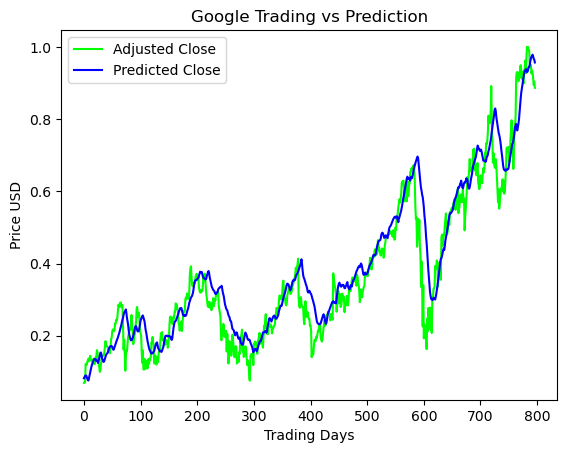

In [91]:
predictions = model.predict(x_test)
plot_prediction(y_test,predictions)

In [92]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00043739 MSE (0.02091389 RMSE)
Test Score: 0.00475761 MSE (0.06897542 RMSE)


In [93]:

def build_improved_model(input_dim, output_dim, return_sequences):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(None, input_dim))) 
    model.add(LSTM(units=128)) 
    model.add(Dense(64)) 
    model.add(Dropout(0.2)) 
    model.add(Dense(1)) 
    return model

In [94]:
batch_size = 100 #Mini batch gradient descent
epochs = 50

# build improved lstm model
model_imp = build_improved_model( x_train.shape[-1],output_dim = unroll_length, return_sequences=True)

start = time.time()
model_imp.compile(loss='mean_squared_error', optimizer='adam')

print('compilation time : ', time.time() - start)

compilation time :  0.008285284042358398


In [95]:
model_imp.fit(x_train, 
          y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.05
         )

Epoch 1/50
30/30 - 15s - 495ms/step - loss: 0.0157 - val_loss: 0.0069
Epoch 2/50
30/30 - 10s - 318ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 3/50
30/30 - 10s - 337ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 4/50
30/30 - 8s - 259ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/50
30/30 - 12s - 409ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 6/50
30/30 - 9s - 294ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 7/50
30/30 - 9s - 313ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 8/50
30/30 - 9s - 311ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/50
30/30 - 9s - 302ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 10/50
30/30 - 9s - 309ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 11/50
30/30 - 10s - 340ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/50
30/30 - 10s - 344ms/step - loss: 9.4946e-04 - val_loss: 0.0024
Epoch 13/50
30/30 - 8s - 279ms/step - loss: 9.6818e-04 - val_loss: 0.0017
Epoch 14/50
30/30 - 11s - 375ms/step - loss: 9.2715e-04 - val_loss: 0.0014
Epoch 15/5

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step


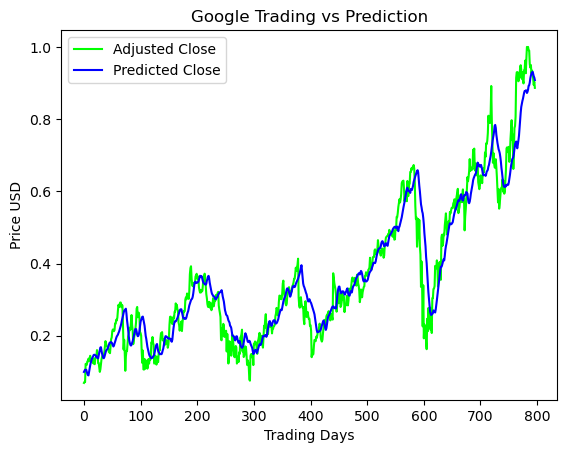

In [96]:
predictions = model_imp.predict(x_test, batch_size=batch_size)
plot_prediction(y_test,predictions)

In [97]:
trainScore = model_imp.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = model_imp.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 0.00052412 MSE (0.02289365 RMSE)
Test Score: 0.00405159 MSE (0.06365210 RMSE)
